# SEIR with synthetic data

To-do:

- More smoothing
- Compartwise + all compartments
- Vary time intervals
- More regions
- Check warnings

In [549]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [550]:
import pandas as pd

import datetime
from datetime import timedelta, datetime
import copy
import os
import json
import sys
sys.path.append('../../')

from utils.enums import Columns
from utils.util import read_config, train_test_split
from utils.data import cities
from utils.loss import Loss_Calculator

from data.dataloader import Covid19IndiaLoader
from data.processing import get_dataframes_cached, get_data

from main.ihme.fitting import single_cycle, create_output_folder
from main.seir.fitting import get_regional_data, data_setup, run_cycle

from models.seir.seir_testing import SEIR_Testing
from main.seir.forecast import get_forecast

from viz.forecast import plot_forecast_agnostic
from viz.fit import plot_fit

## Functions to create custom dataset

In [551]:
def get_custom_dataset(df_actual, df_synthetic, use_actual=True, use_synthetic=True,
                       start_date=None, allowance=5, split1=15, split2=15, split3=15):

    if start_date is None:
        start_date = df_actual['date'].min()
    else:
        start_date = pd.to_datetime(start_date, dayfirst=False)
        
    threshold = start_date - timedelta(days=1)

    _, df_actual = train_test_split(df_actual, threshold)
    _, df_synthetic = train_test_split(df_synthetic, threshold)
        
    test_size = split3
    end_of_train = start_date + timedelta(allowance+split1+split2 - 1)
    
    properties = {
        "allowance_before_train": allowance,
        "total_length": allowance+split1+split2+split3,
        "train_length (s1+s2)": split1+split2,
        "test_length (s3)": test_size,
        "s1_length": split1,
        "s2_length": split2,
        "use_synthetic_s2": (use_actual and use_synthetic)
    }
    
    df_train, df_test = train_test_split(df_actual, end_of_train)

    if not use_synthetic:  
        pass
    elif not use_actual:
        df_train, _ = train_test_split(df_synthetic, end_of_train)
    elif use_actual and use_synthetic:
        end_of_actual = start_date + timedelta(split1 + allowance - 1)
        df_train1, _ = train_test_split(df_actual, end_of_actual)
        df_train_temp, _ = train_test_split(df_synthetic, end_of_train)
        _, df_train2 = train_test_split(df_train_temp, end_of_actual)
        df_train = pd.concat([df_train1, df_train2], axis=0)
    else:
        raise Exception("Train and test sets not defined.")

    if len(df_test) > test_size:
        df_test = df_test.head(test_size)
    else:
        raise Exception("Test set size {} greater than size available {}.".format(test_size, len(df_test)))
        
    df_train.reset_index(inplace=True, drop=True)
        
    df = pd.concat([df_train, df_test], axis=0)
    
    return df, df_train, df_test, properties

In [552]:
def format_custom_dataset(dataset, state=None, district=None, compartments=Columns.curve_fit_compartments()):
    """Format custom dataset according to the format required by the SEIR model. Select/insert required columns."""
    col_names = [col.name for col in compartments]
    dataset = dataset[['date']+col_names]
    if state:
        dataset.insert(1, "state", state)
    if district:
        dataset.insert(2, "district", district)
    return dataset

In [553]:
def insert_custom_dataset_into_dataframes(dataframes, dataset, start_date=None, compartments=None):
    """Replace original df_district with one or more columns from custom dataset."""
    if compartments is None:
        compartments = Columns.curve_fit_compartments()
        col_names = [col.name for col in compartments]
    else:
        col_names = compartments
        
    df_district, df_raw = dataframes
    
    if start_date is None:
        start_date = df_district['date'].min()
    else:
        start_date = pd.to_datetime(start_date, dayfirst=False)
    
    threshold = start_date - timedelta(days=1)

    _, df_district = train_test_split(df_district, threshold)
    _, df_raw = train_test_split(df_raw, threshold)
    
    num_rows = dataset.shape[0]
    df_district = df_district.head(num_rows)
    for col in col_names:
        df_district[col] = dataset[col].values
    return (df_district, df_raw)

## Check data

In [554]:
district = 'Pune'
state = 'Maharashtra'
disable_tracker = True
allowance = 5 # number of days of actuals to have before s1 starts for rolling average
s1 = 10
s2 = 10
s3 = 10

In [555]:
loader = Covid19IndiaLoader()
dataframes = loader.get_covid19india_api_data()

data = get_data(dataframes, state, district, disable_tracker=disable_tracker)
data

fetching from athenadb...


,state,district,date,total_infected,hospitalised,recovered,deceased
0,maharashtra,pune,2020-04-19,586,482,55,49
1,maharashtra,pune,2020-04-20,666,549,68,49
2,maharashtra,pune,2020-04-21,708,570,87,51
3,maharashtra,pune,2020-04-22,772,595,122,55
4,maharashtra,pune,2020-04-23,876,687,130,59
...,...,...,...,...,...,...,...
59,maharashtra,pune,2020-06-17,10643,3449,6713,481
60,maharashtra,pune,2020-06-18,11115,3722,6906,487
61,maharashtra,pune,2020-06-19,11465,3909,7063,493
62,maharashtra,pune,2020-06-20,11854,4086,7264,504


## Setup

In [556]:
start_date = data['date'].min() + timedelta(10)
ihme_start_date = start_date + timedelta(allowance)
# Allow for a few days of actuals before s1 for rolling average
period = s1 + s2
smooth_jump = True if district == "Mumbai" else False
replace = ['hospitalised', 'total_infected', 'deceased', 'recovered']

In [557]:
now = datetime.now().strftime("%Y%m%d-%H%M%S")
folder = f'{district}/{str(now)}'
output_folder = create_output_folder(f'synth/{folder}/')

## IHME model (I1)

### Setup

In [558]:
dist, st, area_names = cities[district.lower()]
config, model_params = read_config('../../scripts/ihme/config/default.yaml')
config['start_date'] = ihme_start_date
config['period'] = period
config['disable_tracker'] = disable_tracker
config['max_evals'] = 100
config['test_size'] = s2
# config['log'] = False

### Train

In [559]:
ihme_res = single_cycle(dist, st, area_names, model_params, **config)

../../cache/Pune_ts_athena_25062020.pkl
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/Users/nayana/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s

/Users/nayana/anaconda3/envs/covid/lib/python3.8/site-packages/curvefit-0.0.0-py3.8.egg/curvefit/pipelines/_pipeline.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.all_data.sort_values([col_group, col_t], inplace=True)

/Users/nayana/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*input

 51%|█████     | 51/100 [01:36<00:58,  1.19s/trial, best loss: 0.012771658198103048]

/Users/nayana/anaconda3/envs/covid/lib/python3.8/site-packages/curvefit-0.0.0-py3.8.egg/curvefit/core/functions.py:92: RuntimeWarning: overflow encountered in square
  return 0.5*sum(x**2)

/Users/nayana/anaconda3/envs/covid/lib/python3.8/site-packages/curvefit-0.0.0-py3.8.egg/curvefit/core/functions.py:92: RuntimeWarning: invalid value encountered in cdouble_scalars
  return 0.5*sum(x**2)



 65%|██████▌   | 65/100 [01:56<00:53,  1.53s/trial, best loss: 0.0014300457261756975]

../../models/ihme/model.py:71: RuntimeWarning: overflow encountered in exp
  exp_fun = lambda x : np.exp(x)

/Users/nayana/anaconda3/envs/covid/lib/python3.8/site-packages/curvefit-0.0.0-py3.8.egg/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)

/Users/nayana/anaconda3/envs/covid/lib/python3.8/site-packages/curvefit-0.0.0-py3.8.egg/curvefit/core/functions.py:49: RuntimeWarning: invalid value encountered in multiply
  x = params[0]*(t - params[1])



100%|██████████| 100/100 [02:50<00:00,  1.70s/trial, best loss: 0.0014300457261756975]
Running PV for 1.0
100%|██████████| 100/100 [01:30<00:00,  1.10trial/s, best loss: 0.013015999948336849]
Running PV for 1.0
100%|██████████| 100/100 [01:42<00:00,  1.02s/trial, best loss: 0.629301609157568]
Running PV for 1.0
100%|██████████| 100/100 [01:31<00:00,  1.09trial/s, best loss: 0.07010619007292437]
Running PV for 1.0


### Outputs

In [560]:
res = copy.copy(ihme_res)

In [561]:
%matplotlib inline
ihme_df_train, ihme_df_val = ihme_res['df_train'], ihme_res['df_test']
ihme_df_train_nora, ihme_df_val_nora = ihme_res['df_train_nora'], ihme_res['df_test_nora']
ihme_df_true = ihme_res['df_district']
ihme_df_pred = ihme_res['df_prediction']

makesum = copy.copy(ihme_df_pred)
makesum['total_infected'] = ihme_df_pred['recovered'] + ihme_df_pred['deceased'] + ihme_df_pred['hospitalised']

plot_fit(
    makesum.reset_index(), ihme_df_train, ihme_df_val, ihme_df_train_nora, ihme_df_val_nora, 
    s1, st, dist, which_compartments=[c.name for c in Columns.curve_fit_compartments()],
    description = 'Train and test',
    savepath=os.path.join(output_folder, 'ihme.png'))

plot_forecast_agnostic(ihme_df_true, makesum.reset_index(), model_name='IHME M1', 
                       dist=dist, state=st, filename=os.path.join(output_folder, 'ihme-forecast.png'))

,date,recovered,deceased,hospitalised,total_infected,log_recovered_rate,log_deceased_rate,log_hospitalised_rate,log_total_infected_rate
0,2020-05-04,465.906570,106.998433,1321.946275,1856.407348,-9.915359,-11.386530,-8.872483,-8.532946
1,2020-05-05,528.993484,112.889251,1324.917142,1950.755906,-9.788368,-11.332937,-8.870239,-8.483372
2,2020-05-06,599.365482,118.915475,1327.888755,2048.584111,-9.663472,-11.280931,-8.867998,-8.434440
3,2020-05-07,677.681332,125.066818,1330.861093,2149.942170,-9.540667,-11.230496,-8.865762,-8.386148
4,2020-05-08,764.635143,131.332230,1333.834136,2254.876567,-9.419945,-11.181614,-8.863531,-8.338493
5,2020-05-09,860.955205,137.699956,1336.807864,2363.429820,-9.301301,-11.134267,-8.861304,-8.291475
6,2020-05-10,967.402365,144.157601,1339.782257,2475.640242,-9.184729,-11.088437,-8.859081,-8.245090
7,2020-05-11,1084.767897,150.692201,1342.757295,2591.541709,-9.070223,-11.044105,-8.856863,-8.199336
8,2020-05-12,1213.870872,157.290300,1345.732958,2711.163433,-8.957774,-11.001251,-8.854650,-8.154211
9,2020-05-13,1355.554970,163.938037,1348.709225,2834.529739,-8.847378,-10.959855,-8.852441,-8.109713


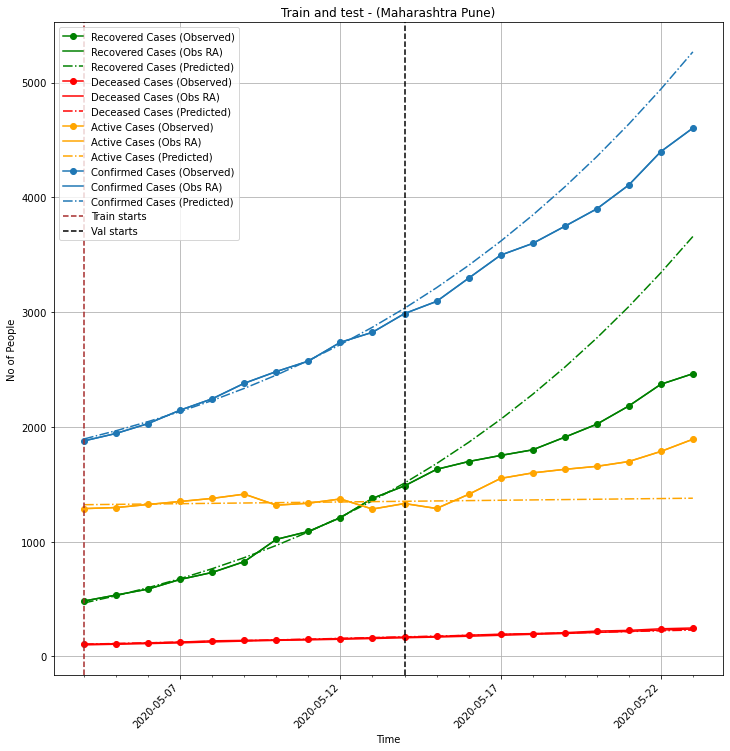

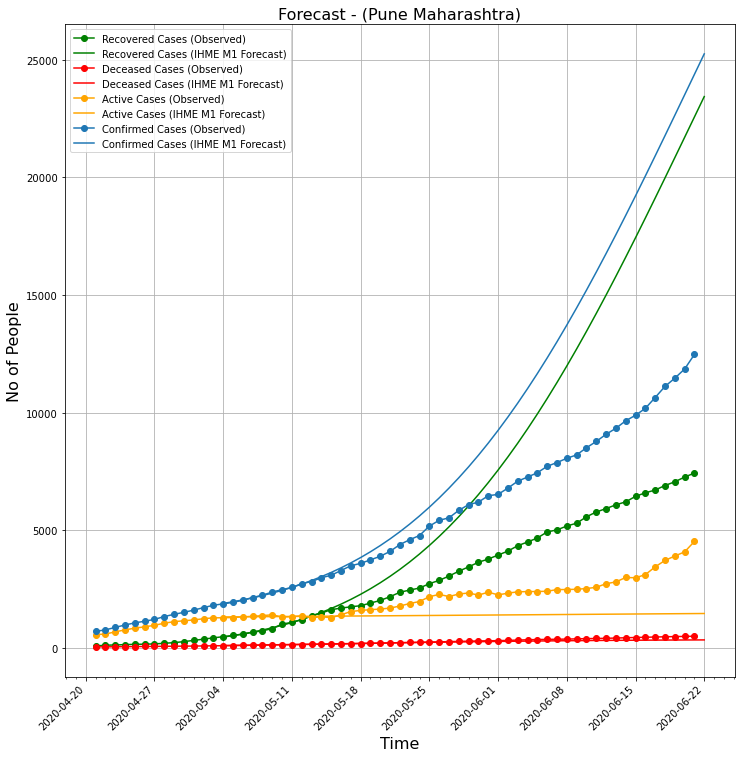

In [562]:
ihme_res['df_prediction']

In [563]:
ihme_res['df_prediction']['total_infected'] = makesum['total_infected']

In [564]:
ihme_res['df_prediction']

,date,recovered,deceased,hospitalised,total_infected,log_recovered_rate,log_deceased_rate,log_hospitalised_rate,log_total_infected_rate
0,2020-05-04,465.906570,106.998433,1321.946275,1894.851277,-9.915359,-11.386530,-8.872483,-8.532946
1,2020-05-05,528.993484,112.889251,1324.917142,1966.799878,-9.788368,-11.332937,-8.870239,-8.483372
2,2020-05-06,599.365482,118.915475,1327.888755,2046.169713,-9.663472,-11.280931,-8.867998,-8.434440
3,2020-05-07,677.681332,125.066818,1330.861093,2133.609243,-9.540667,-11.230496,-8.865762,-8.386148
4,2020-05-08,764.635143,131.332230,1333.834136,2229.801509,-9.419945,-11.181614,-8.863531,-8.338493
5,2020-05-09,860.955205,137.699956,1336.807864,2335.463026,-9.301301,-11.134267,-8.861304,-8.291475
6,2020-05-10,967.402365,144.157601,1339.782257,2451.342223,-9.184729,-11.088437,-8.859081,-8.245090
7,2020-05-11,1084.767897,150.692201,1342.757295,2578.217393,-9.070223,-11.044105,-8.856863,-8.199336
8,2020-05-12,1213.870872,157.290300,1345.732958,2716.894130,-8.957774,-11.001251,-8.854650,-8.154211
9,2020-05-13,1355.554970,163.938037,1348.709225,2868.202231,-8.847378,-10.959855,-8.852441,-8.109713


In [565]:
ihme_res['df_train']

,recovered,deceased,hospitalised,total_infected,log_recovered_rate,log_deceased_rate,log_hospitalised_rate,log_total_infected_rate,date
13,483,100.666667,1288,1878,-9.879327,-11.386515,-8.898498,-8.521381,2020-05-04
14,535,106.333333,1297,1943,-9.777077,-11.349814,-8.891535,-8.487355,2020-05-05
15,587,112.000000,1324,2029,-9.684319,-11.288659,-8.870931,-8.444046,2020-05-06
16,671,118.000000,1350,2146,-9.550575,-11.231030,-8.851484,-8.387983,2020-05-07
17,732,126.333333,1377,2245,-9.463563,-11.146689,-8.831681,-8.342883,2020-05-08
18,826,133.666667,1414,2380,-9.342749,-11.117701,-8.805166,-8.284488,2020-05-09
19,1020,140.000000,1318,2482,-9.131786,-11.089531,-8.875473,-8.242524,2020-05-10
20,1089,144.333333,1335,2573,-9.066329,-11.055398,-8.862657,-8.206516,2020-05-11
21,1209,149.666667,1372,2737,-8.961795,-11.009488,-8.835319,-8.144726,2020-05-12
22,1377,156.000000,1284,2824,-8.831681,-10.965594,-8.901608,-8.113434,2020-05-13


In [566]:
ihme_res['df_test']

,recovered,deceased,hospitalised,total_infected,log_recovered_rate,log_deceased_rate,log_hospitalised_rate,log_total_infected_rate,date
23,1486,162.666667,1332,2987,-8.755501,-10.929445,-8.864907,-8.057319,2020-05-14
24,1630,168.666667,1289,3093,-8.663009,-10.900289,-8.897722,-8.022447,2020-05-15
25,1698,176.000000,1412,3295,-8.622138,-10.838988,-8.806581,-7.959182,2020-05-16
26,1751,184.333333,1551,3496,-8.591402,-10.791486,-8.712689,-7.899969,2020-05-17
27,1800,192.666667,1599,3598,-8.563802,-10.766039,-8.682210,-7.871210,2020-05-18
28,1910,200.000000,1630,3747,-8.504485,-10.726625,-8.663009,-7.830633,2020-05-19
29,2023,209.000000,1656,3899,-8.447007,-10.661181,-8.647184,-7.790868,2020-05-20
30,2182,218.333333,1698,4107,-8.371347,-10.634394,-8.622138,-7.738896,2020-05-21
31,2371,229.666667,1786,4398,-8.288277,-10.574547,-8.571610,-7.670439,2020-05-22
32,2463,238.666667,1892,4603,-8.250208,-10.545915,-8.513954,-7.624880,2020-05-23


In [567]:
i1 = ihme_res['df_loss'].T[['hospitalised', 'deceased', 'recovered', 'total_infected']]
i1.to_csv(output_folder+"ihme.csv")
ihme_res['df_loss']

,train,test,train_no_xform,test_no_xform
recovered,2.39919,19.1358,0.254863,2.72195
deceased,1.03476,3.23342,0.0922785,0.294796
hospitalised,2.43698,17.2559,0.274443,1.75472
total_infected,0.6136,3.27709,0.0736062,0.409872


In [568]:
ihme_res['df_district_nora']

,recovered,deceased,hospitalised,total_infected,log_recovered_rate,log_deceased_rate,log_hospitalised_rate,log_total_infected_rate,date
0,55,49,482,586,-12.052011,-12.167524,-9.881400,-9.686024,2020-04-19
1,68,49,549,666,-11.839836,-12.167524,-9.751245,-9.558054,2020-04-20
2,87,51,570,708,-11.593436,-12.127518,-9.713708,-9.496900,2020-04-21
3,122,55,595,772,-11.255323,-12.052011,-9.670782,-9.410359,2020-04-22
4,130,59,687,876,-11.191809,-11.981806,-9.527010,-9.283978,2020-04-23
...,...,...,...,...,...,...,...,...,...
59,6713,481,3449,10643,-7.247543,-9.883477,-7.913504,-6.786686,2020-06-17
60,6906,487,3722,11115,-7.219198,-9.871080,-7.837327,-6.743293,2020-06-18
61,7063,493,3909,11465,-7.196719,-9.858835,-7.788307,-6.712290,2020-06-19
62,7264,504,4086,11854,-7.168658,-9.836768,-7.744022,-6.678923,2020-06-20


## SEIR model (C1)

### Setup

In [569]:
c1_input = get_regional_data(dataframes, st, dist, (not disable_tracker), None, None, granular_data=False, 
                             smooth_jump=smooth_jump, smoothing_length=33, smoothing_method='weighted', t_recov=14,
                             return_extra=False)
c1_input

fetching from athenadb...


(          state district       date  total_infected  hospitalised  recovered  \
 0   maharashtra     pune 2020-04-19             586           482         55   
 1   maharashtra     pune 2020-04-20             666           549         68   
 2   maharashtra     pune 2020-04-21             708           570         87   
 3   maharashtra     pune 2020-04-22             772           595        122   
 4   maharashtra     pune 2020-04-23             876           687        130   
 ..          ...      ...        ...             ...           ...        ...   
 59  maharashtra     pune 2020-06-17           10643          3449       6713   
 60  maharashtra     pune 2020-06-18           11115          3722       6906   
 61  maharashtra     pune 2020-06-19           11465          3909       7063   
 62  maharashtra     pune 2020-06-20           11854          4086       7264   
 63  maharashtra     pune 2020-06-21           12474          4529       7435   
 
     deceased  
 0        

In [570]:
model=SEIR_Testing
variable_param_ranges=None
data_from_tracker=False
granular_data=False
filename=None
data_format='new'
train_period=s1
val_period=s2
num_evals=1500
N=1e7
initialisation='intermediate'
which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered']
smooth_jump=smooth_jump
smoothing_length=33
smoothing_method='weighted'

In [571]:
c1_df_district, c1_df_raw = c1_input
c1_df_district = c1_df_district.head(train_period+val_period+allowance)

print(c1_df_district)

predictions_dict_c1 = dict()

observed_dataframes = data_setup(c1_df_district, c1_df_raw, val_period)

print('train\n', observed_dataframes['df_train'])
print('val\n', observed_dataframes['df_val'])

          state district       date  total_infected  hospitalised  recovered  \
0   maharashtra     pune 2020-04-19             586           482         55   
1   maharashtra     pune 2020-04-20             666           549         68   
2   maharashtra     pune 2020-04-21             708           570         87   
3   maharashtra     pune 2020-04-22             772           595        122   
4   maharashtra     pune 2020-04-23             876           687        130   
5   maharashtra     pune 2020-04-24             980           772        146   
6   maharashtra     pune 2020-04-25            1070           845        159   
7   maharashtra     pune 2020-04-26            1139           902        165   
8   maharashtra     pune 2020-04-27            1217           966        176   
9   maharashtra     pune 2020-04-28            1339          1057        203   
10  maharashtra     pune 2020-04-29            1432          1121        230   
11  maharashtra     pune 2020-04-30     

### Train

100%|██████████| 1500/1500 [02:55<00:00,  8.56trial/s, best loss: 9.951980067838592]
best parameters
 {'E_hosp_ratio': 0.42627914086880975, 'I_hosp_ratio': 0.41961947124150384, 'P_fatal': 0.13274129927187112, 'T_inc': 4.090168972200085, 'T_inf': 3.3344774745024752, 'T_recov_severe': 37.34372188773342, 'lockdown_R0': 1.0850207848150564}


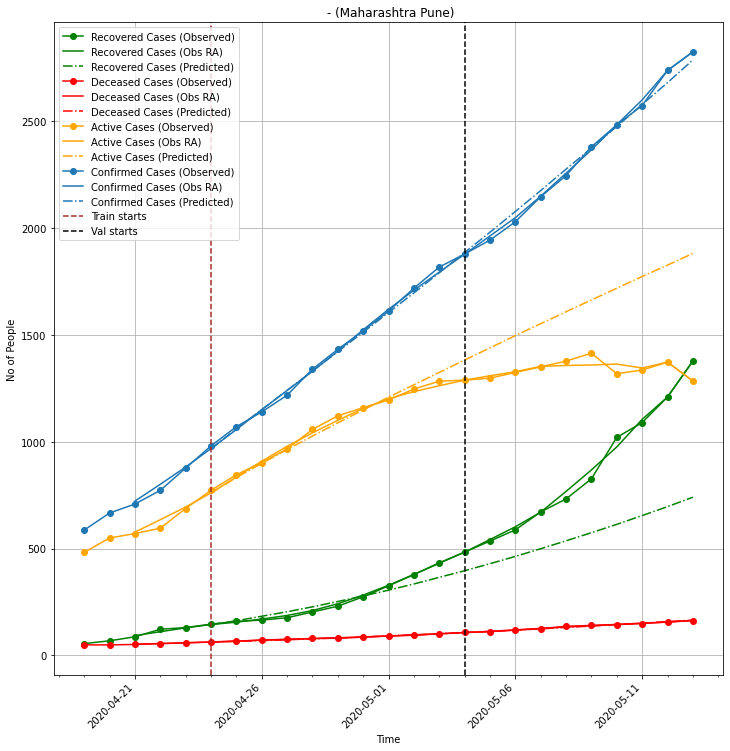

In [572]:
predictions_dict_c1['m1'] = run_cycle(
        st, dist, observed_dataframes, 
        model=model, variable_param_ranges=variable_param_ranges,
        data_from_tracker=data_from_tracker, train_period=train_period, 
        which_compartments=which_compartments, N=N,
        num_evals=num_evals, initialisation=initialisation
    )

### Outputs

In [573]:
predictions_dict_c1['m1']['ax'].figure.savefig(output_folder+'seir-c1.png')

In [574]:
predictions_dict_c1['m1']['df_prediction']

,date,S,E,I,D_E,D_I,R_mild,R_severe,R_fatal,C,D,hospitalised,recovered,deceased,total_infected
0,2020-04-24,9998389,324,318,0,0,0,659,100,144,62,759,144,62,965
1,2020-04-25,9998287,343,307,0,0,0,722,110,162,66,832,162,66,1060
2,2020-04-26,9998188,357,301,0,0,0,780,118,183,69,898,183,69,1150
3,2020-04-27,9998091,366,300,0,0,0,837,126,204,73,963,204,73,1240
4,2020-04-28,9997993,373,300,0,0,0,892,134,227,77,1026,227,77,1330
5,2020-04-29,9997895,379,302,0,0,0,946,142,252,81,1088,252,81,1421
6,2020-04-30,9997796,384,304,0,0,0,999,149,278,86,1148,278,86,1512
7,2020-05-01,9997697,389,307,0,0,0,1051,157,305,91,1208,305,91,1604
8,2020-05-02,9997596,394,310,0,0,0,1102,164,334,96,1266,334,96,1696
9,2020-05-03,9997495,398,314,0,0,0,1153,171,365,101,1324,365,101,1790


In [575]:
predictions_dict_c1['m1']['df_val']

,state,district,date,total_infected,hospitalised,recovered,deceased
0,maharashtra,pune,2020-05-04,1877.0,1287.6,483.2,106.2
1,maharashtra,pune,2020-05-05,1962.6,1308.4,541.8,112.4
2,maharashtra,pune,2020-05-06,2048.2,1327.2,601.6,119.4
3,maharashtra,pune,2020-05-07,2148.6,1352.4,670.2,126.0
4,maharashtra,pune,2020-05-08,2256.4,1356.6,767.2,132.6
5,maharashtra,pune,2020-05-09,2365.2,1358.8,867.6,138.8
6,maharashtra,pune,2020-05-10,2483.4,1363.2,975.2,145.0
7,maharashtra,pune,2020-05-11,2599.2,1344.6,1104.2,150.4
8,maharashtra,pune,2020-05-12,2737.0,1372.0,1209.0,156.0
9,maharashtra,pune,2020-05-13,2824.0,1284.0,1377.0,163.0


In [576]:
c1 = predictions_dict_c1['m1']['df_loss'].T[['hospitalised', 'deceased', 'recovered', 'total_infected']]
c1.to_csv(output_folder+"seir.csv")
predictions_dict_c1['m1']['df_loss']

,train,val
hospitalised,1.67976,17.5109
total_infected,1.03987,1.14234
deceased,1.29311,1.15083
recovered,8.59052,48.1095


## Create custom datasets

In [577]:
df1, train1, test1, prop1 = get_custom_dataset(ihme_res['df_district_nora'], ihme_res['df_prediction'], 
                                               use_synthetic=False, start_date=start_date,
                                               allowance=allowance, split1=s1, split2=s2, split3=s3)
train1 = format_custom_dataset(train1, st, dist)
df1 = format_custom_dataset(df1, st, dist)
train1

,date,state,district,recovered,deceased,hospitalised,total_infected
0,2020-04-29,Maharashtra,Pune,230,81,1121,1432
1,2020-04-30,Maharashtra,Pune,274,85,1159,1518
2,2020-05-01,Maharashtra,Pune,325,91,1195,1611
3,2020-05-02,Maharashtra,Pune,378,94,1246,1718
4,2020-05-03,Maharashtra,Pune,433,101,1283,1817
5,2020-05-04,Maharashtra,Pune,483,107,1288,1878
6,2020-05-05,Maharashtra,Pune,535,111,1297,1943
7,2020-05-06,Maharashtra,Pune,587,118,1324,2029
8,2020-05-07,Maharashtra,Pune,671,125,1350,2146
9,2020-05-08,Maharashtra,Pune,732,136,1377,2245


In [578]:
df2, train2, test2, prop2 = get_custom_dataset(ihme_res['df_district_nora'], ihme_res['df_prediction'],
                                               start_date=start_date,
                                               allowance=allowance, split1=s1, split2=s2, split3=s3)
train2 = format_custom_dataset(train2, st, dist)
df2 = format_custom_dataset(df2, st, dist)
train2

,date,state,district,recovered,deceased,hospitalised,total_infected
0,2020-04-29,Maharashtra,Pune,230.000000,81.000000,1121.000000,1432.000000
1,2020-04-30,Maharashtra,Pune,274.000000,85.000000,1159.000000,1518.000000
2,2020-05-01,Maharashtra,Pune,325.000000,91.000000,1195.000000,1611.000000
3,2020-05-02,Maharashtra,Pune,378.000000,94.000000,1246.000000,1718.000000
4,2020-05-03,Maharashtra,Pune,433.000000,101.000000,1283.000000,1817.000000
5,2020-05-04,Maharashtra,Pune,483.000000,107.000000,1288.000000,1878.000000
6,2020-05-05,Maharashtra,Pune,535.000000,111.000000,1297.000000,1943.000000
7,2020-05-06,Maharashtra,Pune,587.000000,118.000000,1324.000000,2029.000000
8,2020-05-07,Maharashtra,Pune,671.000000,125.000000,1350.000000,2146.000000
9,2020-05-08,Maharashtra,Pune,732.000000,136.000000,1377.000000,2245.000000


In [579]:
df3, train3, test3, prop3 = get_custom_dataset(ihme_res['df_district_nora'], predictions_dict_c1['m1']['df_prediction'], 
                                               start_date=start_date,
                                               allowance=allowance, split1=s1, split2=s2, split3=s3)
train3 = format_custom_dataset(train3, st, dist)
df3 = format_custom_dataset(df3, st, dist)

### Save custom datasets

In [580]:
df1.to_csv(output_folder+"Dataset1.csv")
df2.to_csv(output_folder+"Dataset2.csv")
df3.to_csv(output_folder+"Dataset3.csv")

## SEIR Model using custom datasets

### Setup

In [581]:
input_df = get_regional_data(dataframes, st, dist, (not disable_tracker), None, None, granular_data=False, 
                             smooth_jump=smooth_jump, smoothing_length=33, smoothing_method='weighted', t_recov=14,
                             return_extra=False)

fetching from athenadb...


In [582]:
input_1 = insert_custom_dataset_into_dataframes(input_df, df1, 
                                                start_date=start_date, compartments=replace)
input_1

(          state district       date  total_infected  hospitalised  recovered  \
 10  maharashtra     pune 2020-04-29            1432          1121        230   
 11  maharashtra     pune 2020-04-30            1518          1159        274   
 12  maharashtra     pune 2020-05-01            1611          1195        325   
 13  maharashtra     pune 2020-05-02            1718          1246        378   
 14  maharashtra     pune 2020-05-03            1817          1283        433   
 15  maharashtra     pune 2020-05-04            1878          1288        483   
 16  maharashtra     pune 2020-05-05            1943          1297        535   
 17  maharashtra     pune 2020-05-06            2029          1324        587   
 18  maharashtra     pune 2020-05-07            2146          1350        671   
 19  maharashtra     pune 2020-05-08            2245          1377        732   
 20  maharashtra     pune 2020-05-09            2380          1414        826   
 21  maharashtra     pune 20

In [583]:
input_2 = insert_custom_dataset_into_dataframes(input_df, df2, 
                                                start_date=start_date, compartments=replace)
input_2

(          state district       date  total_infected  hospitalised  \
 10  maharashtra     pune 2020-04-29     1432.000000   1121.000000   
 11  maharashtra     pune 2020-04-30     1518.000000   1159.000000   
 12  maharashtra     pune 2020-05-01     1611.000000   1195.000000   
 13  maharashtra     pune 2020-05-02     1718.000000   1246.000000   
 14  maharashtra     pune 2020-05-03     1817.000000   1283.000000   
 15  maharashtra     pune 2020-05-04     1878.000000   1288.000000   
 16  maharashtra     pune 2020-05-05     1943.000000   1297.000000   
 17  maharashtra     pune 2020-05-06     2029.000000   1324.000000   
 18  maharashtra     pune 2020-05-07     2146.000000   1350.000000   
 19  maharashtra     pune 2020-05-08     2245.000000   1377.000000   
 20  maharashtra     pune 2020-05-09     2380.000000   1414.000000   
 21  maharashtra     pune 2020-05-10     2482.000000   1318.000000   
 22  maharashtra     pune 2020-05-11     2573.000000   1335.000000   
 23  maharashtra    

In [584]:
input_3 = insert_custom_dataset_into_dataframes(input_df, df3, 
                                                start_date=start_date, compartments=replace)
input_3

(          state district       date  total_infected  hospitalised  recovered  \
 10  maharashtra     pune 2020-04-29            1432          1121        230   
 11  maharashtra     pune 2020-04-30            1518          1159        274   
 12  maharashtra     pune 2020-05-01            1611          1195        325   
 13  maharashtra     pune 2020-05-02            1718          1246        378   
 14  maharashtra     pune 2020-05-03            1817          1283        433   
 15  maharashtra     pune 2020-05-04            1878          1288        483   
 16  maharashtra     pune 2020-05-05            1943          1297        535   
 17  maharashtra     pune 2020-05-06            2029          1324        587   
 18  maharashtra     pune 2020-05-07            2146          1350        671   
 19  maharashtra     pune 2020-05-08            2245          1377        732   
 20  maharashtra     pune 2020-05-09            2380          1414        826   
 21  maharashtra     pune 20

In [585]:
model=SEIR_Testing
variable_param_ranges=None
data_from_tracker=(not disable_tracker)
granular_data=False
filename=None
data_format='new'
train_period=s1+s2
val_period=s3
num_evals=1500
N=1e7
initialisation='intermediate'
which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered']
smooth_jump=smooth_jump
smoothing_length=33
smoothing_method='weighted'

### Experiment 1 - Ground truth data

splitting data ..
splitting data ..
train
           state district       date  total_infected  hospitalised  recovered  \
0   maharashtra     pune 2020-05-01          1619.2        1200.8      328.0   
1   maharashtra     pune 2020-05-02          1708.4        1234.2      378.6   
2   maharashtra     pune 2020-05-03          1793.4        1261.8      430.8   
3   maharashtra     pune 2020-05-04          1877.0        1287.6      483.2   
4   maharashtra     pune 2020-05-05          1962.6        1308.4      541.8   
5   maharashtra     pune 2020-05-06          2048.2        1327.2      601.6   
6   maharashtra     pune 2020-05-07          2148.6        1352.4      670.2   
7   maharashtra     pune 2020-05-08          2256.4        1356.6      767.2   
8   maharashtra     pune 2020-05-09          2365.2        1358.8      867.6   
9   maharashtra     pune 2020-05-10          2483.4        1363.2      975.2   
10  maharashtra     pune 2020-05-11          2599.2        1344.6     1104.2 

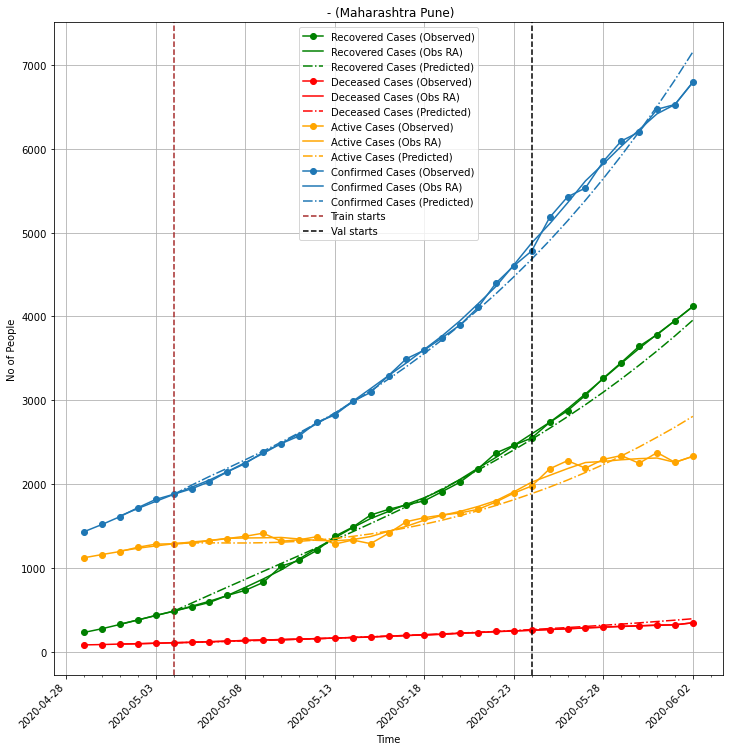

In [586]:
predictions_dict_1 = dict()

observed_dataframes = data_setup(input_1[0], input_1[1], val_period)

print('train\n', observed_dataframes['df_train'])
print('val\n', observed_dataframes['df_val'])

predictions_dict_1['m1'] = run_cycle(
        st, dist, observed_dataframes, 
        model=model, variable_param_ranges=variable_param_ranges,
        data_from_tracker=data_from_tracker, train_period=train_period, 
        which_compartments=which_compartments, N=N,
        num_evals=num_evals, initialisation=initialisation
    )

In [587]:
predictions_dict_1['m1']['df_train']

,state,district,date,total_infected,hospitalised,recovered,deceased
0,maharashtra,pune,2020-05-01,1619.2,1200.8,328.0,90.4
1,maharashtra,pune,2020-05-02,1708.4,1234.2,378.6,95.6
2,maharashtra,pune,2020-05-03,1793.4,1261.8,430.8,100.8
3,maharashtra,pune,2020-05-04,1877.0,1287.6,483.2,106.2
4,maharashtra,pune,2020-05-05,1962.6,1308.4,541.8,112.4
5,maharashtra,pune,2020-05-06,2048.2,1327.2,601.6,119.4
6,maharashtra,pune,2020-05-07,2148.6,1352.4,670.2,126.0
7,maharashtra,pune,2020-05-08,2256.4,1356.6,767.2,132.6
8,maharashtra,pune,2020-05-09,2365.2,1358.8,867.6,138.8
9,maharashtra,pune,2020-05-10,2483.4,1363.2,975.2,145.0


In [588]:
predictions_dict_1['m1']['df_val']

,state,district,date,total_infected,hospitalised,recovered,deceased
0,maharashtra,pune,2020-05-24,4878.2,2023.2,2598.8,256.2
1,maharashtra,pune,2020-05-25,5105.2,2104.0,2736.4,264.8
2,maharashtra,pune,2020-05-26,5354.8,2184.4,2896.6,273.8
3,maharashtra,pune,2020-05-27,5617.0,2257.0,3076.6,283.4
4,maharashtra,pune,2020-05-28,5821.0,2270.2,3258.4,292.4
5,maharashtra,pune,2020-05-29,6030.0,2289.6,3439.8,300.6
6,maharashtra,pune,2020-05-30,6229.2,2303.4,3618.0,307.8
7,maharashtra,pune,2020-05-31,6418.0,2310.8,3789.0,318.2
8,maharashtra,pune,2020-06-01,6529.0,2259.0,3950.0,320.0
9,maharashtra,pune,2020-06-02,6795.0,2331.0,4119.0,345.0


In [589]:
t1 = predictions_dict_1['m1']['df_loss'].T[['hospitalised', 'deceased', 'recovered', 'total_infected']]
t1['exp'] = 1
predictions_dict_1['m1']['df_loss']

,train,val
hospitalised,3.41547,8.03801
total_infected,1.3208,3.26015
deceased,1.5075,8.35595
recovered,5.19599,4.19079


In [590]:
predictions_dict_1['m1']['ax'].figure.savefig(output_folder+'seir-exp1.png')

### Experiment 2 - Ground truth + IHME forecast

splitting data ..
splitting data ..
train
           state district       date  total_infected  hospitalised  \
0   maharashtra     pune 2020-05-01     1619.200000   1200.800000   
1   maharashtra     pune 2020-05-02     1708.400000   1234.200000   
2   maharashtra     pune 2020-05-03     1793.400000   1261.800000   
3   maharashtra     pune 2020-05-04     1877.000000   1287.600000   
4   maharashtra     pune 2020-05-05     1962.600000   1308.400000   
5   maharashtra     pune 2020-05-06     2048.200000   1327.200000   
6   maharashtra     pune 2020-05-07     2148.600000   1352.400000   
7   maharashtra     pune 2020-05-08     2256.400000   1356.600000   
8   maharashtra     pune 2020-05-09     2365.200000   1358.800000   
9   maharashtra     pune 2020-05-10     2483.400000   1363.200000   
10  maharashtra     pune 2020-05-11     2599.200000   1344.600000   
11  maharashtra     pune 2020-05-12     2729.798408   1332.137215   
12  maharashtra     pune 2020-05-13     2875.824455   1339.4

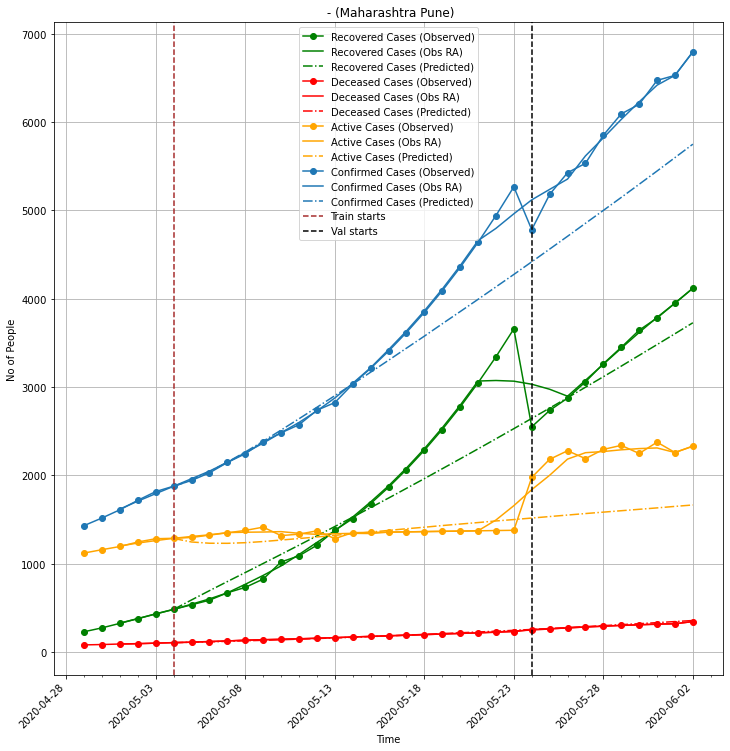

In [591]:
predictions_dict_2 = dict()

observed_dataframes = data_setup(input_2[0], input_2[1], val_period)

print('train\n', observed_dataframes['df_train']) 
print('val\n', observed_dataframes['df_val'])

predictions_dict_2['m1'] = run_cycle(
        st, dist, observed_dataframes, 
        model=model, variable_param_ranges=variable_param_ranges,
        data_from_tracker=data_from_tracker, train_period=train_period, 
        which_compartments=which_compartments, N=N,
        num_evals=num_evals, initialisation=initialisation
    )

In [592]:
t2 = predictions_dict_2['m1']['df_loss'].T[['hospitalised', 'deceased', 'recovered', 'total_infected']]
t2['exp'] = 2
predictions_dict_2['m1']['df_loss']

,train,val
hospitalised,5.09808,41.1934
total_infected,5.46279,15.7225
deceased,2.75563,2.82919
recovered,15.4251,5.52594


In [593]:
predictions_dict_2['m1']['ax'].figure.savefig(output_folder+'seir-exp2.png')

### Experiment 3 - Ground truth + SEIR forecast

In [594]:
predictions_dict_3 = dict()

observed_dataframes = data_setup(input_3[0], input_3[1], val_period)

print('train\n', observed_dataframes['df_train']) 
print('val\n', observed_dataframes['df_val'])

predictions_dict_3['m1'] = run_cycle(
        st, dist, observed_dataframes, 
        model=model, variable_param_ranges=variable_param_ranges,
        data_from_tracker=data_from_tracker, train_period=train_period, 
        which_compartments=which_compartments, N=N,
        num_evals=num_evals, initialisation=initialisation
    )

splitting data ..
splitting data ..
train
           state district       date  total_infected  hospitalised  recovered  \
0   maharashtra     pune 2020-05-01          1619.2        1200.8      328.0   
1   maharashtra     pune 2020-05-02          1708.4        1234.2      378.6   
2   maharashtra     pune 2020-05-03          1793.4        1261.8      430.8   
3   maharashtra     pune 2020-05-04          1877.0        1287.6      483.2   
4   maharashtra     pune 2020-05-05          1962.6        1308.4      541.8   
5   maharashtra     pune 2020-05-06          2048.2        1327.2      601.6   
6   maharashtra     pune 2020-05-07          2148.6        1352.4      670.2   
7   maharashtra     pune 2020-05-08          2256.4        1356.6      767.2   
8   maharashtra     pune 2020-05-09          2365.2        1358.8      867.6   
9   maharashtra     pune 2020-05-10          2483.4        1363.2      975.2   
10  maharashtra     pune 2020-05-11          2599.2        1344.6     1104.2 

IndexError: single positional indexer is out-of-bounds

In [ ]:
t3 = predictions_dict_3['m1']['df_loss'].T[['hospitalised', 'deceased', 'recovered', 'total_infected']]
t3['exp'] = 3
predictions_dict_3['m1']['df_loss']

In [ ]:
predictions_dict_3['m1']['ax'].figure.savefig(output_folder+'seir-exp3.png')

In [ ]:
t = pd.concat([t1, t2, t3], axis=0)
t.index.name="index"
t.sort_values(by='index', inplace=True)
t.to_csv(output_folder+"/exp_"+"_".join(replace)+".csv")

## Plotting

In [ ]:
predictions_dicts = [predictions_dict_1, predictions_dict_2, predictions_dict_3]
train_dicts = [train1, train2, train3]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [ ]:
def plot_across_datasets(exp_no, fig, ax, df_true, df_prediction, df_train, dist, state, 
                         train_start, test_start, graph_start, graph_end,
                         log_scale=False, filename=None,
                         model_name='M2', which_compartments=Columns.which_compartments()):
    for col in Columns.which_compartments():
        if col in which_compartments:
            ax.plot(df_true['date'], df_true[col.name],
                '-o', color=col.color, label=f'{col.label} (Observed)')
            ax.plot(df_train['date'], df_train[col.name],
                'x', color=col.color, label=f'{col.label} (Train data)')
            ax.plot(df_prediction["date"], df_prediction[col.name],
                    '-', color=col.color, label=f'{col.label} ({model_name} Forecast)')
            
            train_start = pd.to_datetime(train_start)
            test_start = pd.to_datetime(test_start)
            graph_start = pd.to_datetime(graph_start)
            graph_end = pd.to_datetime(graph_end)

            line_height = plt.ylim()[1]
            ax.plot([train_start, train_start], [0,line_height], '-', color='red', label='Train starts')
            ax.plot([test_start, test_start], [0,line_height], '-', color='red', label='Test starts')

            ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
            ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
            ax.legend(loc="upper left")
            ax.tick_params(labelrotation=45)
            ax.grid()
            
            ax.set_xlim(graph_start, graph_end)
            
            ax.set_xlabel('Time', fontsize=10)
            ax.set_ylabel('No of People', fontsize=10)
            
            if exp_no == 0: data = 'Using ground truth data'
            if exp_no == 1: data = 'Using data from IHME forecast'
            if exp_no == 2: data = 'Using data from SEIR forecast'
            
            ax.title.set_text('Forecast - {} - {}'.format(dist, data))
        
    return ax

In [ ]:
graph_start = ihme_start_date.strftime("%m-%d-%Y")
train_start = (ihme_start_date + timedelta(s1)).strftime("%m-%d-%Y")
test_start = (ihme_start_date + timedelta(s1+s2)).strftime("%m-%d-%Y")
graph_end = (ihme_start_date + timedelta(s1+s2+s3)).strftime("%m-%d-%Y")

for col in range(4):
    fig, ax = plt.subplots(3, sharex=True, sharey=True, figsize=(15, 12))
    for row in range(len(ax)):
        ax[row] = plot_across_datasets(row, fig, ax[row], input_df[0], 
                                       predictions_dicts[row]['m1']['df_prediction'], 
                                       predictions_dicts[row]['m1']['df_district'], 
                                       district, state, train_start, test_start, graph_start, graph_end,
                                       model_name='', which_compartments=[Columns.which_compartments()[col]],)
        
        filename = output_folder+Columns.which_compartments()[col].name
        fig.savefig(filename)

## Params

In [ ]:
params_dict = {
    'compartments_replaced': replace,
    'dataset_properties': {
        'exp1': prop1,
        'exp2': prop2,
        'exp3': prop3
    }
}

with open(output_folder+'params.json', 'w') as outfile:
    json.dump(params_dict, outfile, indent=4)
    
    
config['start_date'] = config['start_date'].strftime("%Y-%m-%d")
with open(output_folder+'ihme-config.json', 'w') as outfile:
    json.dump(config, outfile, indent=4)

In [ ]:
config

## Extra

In [ ]:
# df_true = input_df[0]

# start_date_pd = pd.to_datetime(start_date, dayfirst=False)

# threshold = start_date_pd - timedelta(days=1)

# _, df_true = train_test_split(df_true, threshold)

# df_true

In [ ]:
# lc = Loss_Calculator()
# df_predictions_1 = get_forecast(predictions_dict_1, train_fit="m1")
# df_loss_1 = lc.create_loss_dataframe_region(df_true, None, df_predictions_1, train_period, 
#                                             which_compartments=which_compartments)
# plot_forecast_agnostic(df_true, df_predictions_1.head(30), dist, st)

In [ ]:
# df_loss_1

In [ ]:
# df_predictions_2 = get_forecast(predictions_dict_2, train_fit="m1")
# df_loss_2 = lc.create_loss_dataframe_region(df_true, None, df_predictions_2.iloc[14:21], train_period, 
#                                             which_compartments=which_compartments)
# plot_forecast_agnostic(df_true, df_predictions_2.head(30), dist, st)

In [ ]:
# df_loss_2

In [ ]:
# df_predictions_3 = get_forecast(predictions_dict_3, train_fit="m1")
# df_loss_3 = lc.create_loss_dataframe_region(df_true, None, df_predictions_3.iloc[14:21], train_period, 
#                                             which_compartments=which_compartments)
# plot_forecast_agnostic(df_true, df_predictions_3.head(30), dist, st)

In [ ]:
# df_loss_3